# Определение стоимости автомобилей  

***Описание проекта***
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.  

***Заказчику важны:***
* качество предсказания;
* скорость предсказания;
* время обучения.  

***Инструкция по выполнению проекта***

Для оценки качества моделей применяйте метрику RMSE.  
Значение метрики RMSE должно быть меньше 2500.

***Описание данных***

Признаки:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя  

Целевой признак:
* Price — цена (евро)

## Подготовка данных

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/autos.csv')
display('Размер датасета:', df.shape)
display(df.head())

'Размер датасета:'

(354369, 16)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
def isna(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
isna(df)

,Total,Percent
NotRepaired,71154,20.079070
VehicleType,37490,10.579368
FuelType,32895,9.282697
Gearbox,19833,5.596709
Model,19705,5.560588
DateCrawled,0,0.000000
Price,0,0.000000
RegistrationYear,0,0.000000
Power,0,0.000000
Kilometer,0,0.000000


In [6]:
df.duplicated().sum()

4

In [7]:
df = df.drop_duplicates()

Видим большое количество пропусков в колонках NotRepaired (была машина в ремонте или нет), VehicleType (тип кузова), FuelType (тип топлива), Gearbox (тип коробки передач) и Model (модель авто). Если удалить эти данные, то от исходного датасета останется менее 70%, поэтому далее попробуем заменить пропуски на "unknown", а разработчикам подкинем идею о настройке обязательных для заполнения полей. Так же имеется 4 полных дубликата, удаляем.

Избавимся от колонок, не учавствующих в предсказании цены: дата скачивания анкеты из базы, месяц регистрации автомобиля, дата создания анкеты, количество фотографий автомобиля (так как везде 0), почтовый индекс владельца анкеты и дата последней активности пользователя.

In [8]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [9]:
for column in df.columns: # чтобы не перебирать по одному, применили цикл
    print(column)
    print(df[column].sort_values().unique()) # уникальные значения с сортировкой по возрастанию
    print()

Price
[    0     1     2 ... 19998 19999 20000]

VehicleType
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

RegistrationYear
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]

Gearbox
['auto' 'manual' nan]

Power
[    0     1     2     3     4     5     6  

Исследуем выбросы в годе регистрации и мощности автомобилей (цену не трогаем, т.к. автовладельцы впролне могут устанавливать любую стоимость).

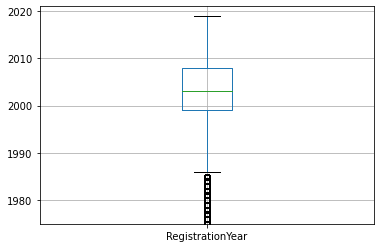

In [10]:
df.boxplot('RegistrationYear')
plt.ylim(1975, 2021);

In [11]:
df['RegistrationYear'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Видим разброс дат регистрации. Можно было бы взять за основу 1886 год - год изобретения первого в мире прототипа современного автомобиля Карлом Бенцем, но ограничимся 1986 и 2019 годом.

In [12]:
(len(df) - len(df.query('2019 >= RegistrationYear >= 1986'))) / len(df) * 100

1.7803676999703695

Выбросы менее 2%, можно смело избавляться.

In [13]:
df = df.query('2019 >= RegistrationYear >= 1986')

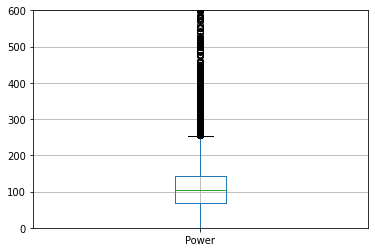

In [14]:
df.boxplot('Power')
plt.ylim(0, 600);

In [15]:
df['Power'].describe()

count    348056.000000
mean        110.694518
std         188.893320
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Максимальную мощность в 1600+л.с. имеет Hennessey Venom F5 стоимостью в $1.6 миллиона, а наш ценовой максимум упирается в €20000, просто взглянем на мощность самых дорогих машин.

In [16]:
df[df['Price'] == 20000].sort_values('Power', ascending=False).head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
25684,20000,sedan,2006,auto,507,m_reihe,150000,petrol,bmw,no
346165,20000,NaN,2016,auto,507,m_reihe,150000,NaN,bmw,NaN
92566,20000,sedan,2006,auto,507,m_reihe,150000,petrol,bmw,no
32658,20000,sedan,2003,auto,500,s_klasse,80000,petrol,mercedes_benz,no
354045,20000,coupe,2006,auto,476,other,125000,petrol,mercedes_benz,no


Кто-то привирает, ведь BMW M-reihe 2006г. имеет мощность 420 л.с., ну да ладно. Избавимся от выбросов > 550 л.с. (опять же несоответствие с ценами), а с минимальным и не знаю что делать, ведь есть автомобиль с мощностью 4.2 л.с. На это чудо стоит взглянуть. 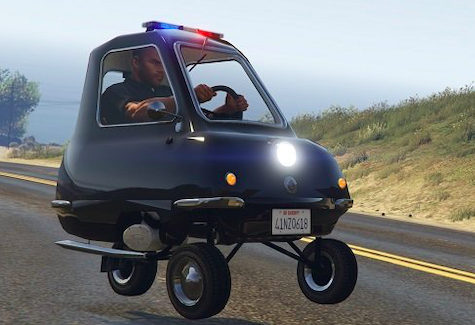

In [17]:
(len(df) - len(df.query('Power < 550'))) / len(df) * 100

0.1126255545084699

In [18]:
df = df.query('Power < 550')

Заменим пропуски.

In [19]:
df.isna().sum()

Price                   0
VehicleType         36274
RegistrationYear        0
Gearbox             18418
Power                   0
Model               18286
Kilometer               0
FuelType            31373
Brand                   0
NotRepaired         68726
dtype: int64

In [20]:
df = df.fillna('unknown')

In [21]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Изменим тип данных в колонке о ремонте, чтобы скормить эту информацию модели.

In [22]:
df['NotRepaired'] = df['NotRepaired'].map({'no': 0, 'yes': 1, 'unknown':2})

Исправим названия колонок.

In [23]:
df.columns = df.columns.str.lower()

In [24]:
df = df.rename(columns = {'vehicletype':'vehicle_type', 'registrationyear':'registration_year', 'fueltype':'fuel_type', 'notrepaired':'not_repaired'})

In [25]:
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         0
dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347664 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              347664 non-null  int64 
 1   vehicle_type       347664 non-null  object
 2   registration_year  347664 non-null  int64 
 3   gearbox            347664 non-null  object
 4   power              347664 non-null  int64 
 5   model              347664 non-null  object
 6   kilometer          347664 non-null  int64 
 7   fuel_type          347664 non-null  object
 8   brand              347664 non-null  object
 9   not_repaired       347664 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 29.2+ MB


In [27]:
df.dtypes.value_counts()

int64     5
object    5
dtype: int64

In [28]:
df = df.reset_index(drop=True)
df.tail()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
347659,0,unknown,2005,manual,0,colt,150000,petrol,mitsubishi,1
347660,2200,unknown,2005,unknown,0,unknown,20000,unknown,sonstige_autos,2
347661,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,0
347662,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,0
347663,3400,wagon,2002,manual,100,golf,150000,gasoline,volkswagen,2


 Сервис по продаже автомобилей предоставил архивные данные с техническими характеристиками, комплектацией и ценами автомобилей. На этапе предобработки датасета размером (354369, 16) мы удалили дубликаты и выбросы, заменили пропуски на "unknown", сделали читабельными заголовки и в итоге получили датафрейм размером (348056, 10), потеряв лишь 1.8% данных.

Теперь данные очищены. Подготовим признаки для обучения. Разделим выборки на обучающую, валидационную и тестовую в соотношении 60%/20%/20% и закодируем категориальные признаки техникой Ordinal Encoder.

In [29]:
target = df['price']
features = df.drop(['price'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.4, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split (features_valid, target_valid, test_size = 0.5, random_state = 12345)

In [30]:
df_ohe = df.copy()
df_ohe = pd.get_dummies(df, drop_first=True)

In [31]:
print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_test.shape)
print(target_valid.shape)


(208598, 9)
(69533, 9)
(69533, 9)
(208598,)
(69533,)
(69533,)


In [32]:
target_ohe = df_ohe['price']
features_ohe = df_ohe.drop(['price'], axis = 1)

features_train_ohe, features_valid, target_train_ohe, target_valid = train_test_split(features_ohe, target_ohe, test_size = 0.4, random_state = 12345)
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split (features_valid, target_valid, test_size = 0.5, random_state = 12345)
features_train_ohe.shape, features_valid_ohe.shape, features_test_ohe.shape

((208598, 308), (69533, 308), (69533, 308))

Отмасштабируем числовые признаки.

In [33]:
numeric = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [34]:
numeric = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])


## Обучение моделей

Напишем функцию для расчета метрики RMSE с помощию функции make_scorer:

In [35]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### Линейная регрессия

In [36]:
%%time

regression = LinearRegression()

regression.fit(features_train_ohe, target_train_ohe)

regression_cv_score = pd.Series(cross_val_score(regression,features_train_ohe,target_train_ohe,scoring=RMSE_score,cv=3)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 2574.4901729591397
CPU times: user 50.4 s, sys: 28.3 s, total: 1min 18s
Wall time: 1min 18s


Модель линейной регрессии заняла 1min 15s с точностью RMSE = 2574.49. Данную модель не будем рассматривать при анализе.

### Случайный лес

In [37]:
%%time

forest = RandomForestRegressor()

forest_parametrs = { 'n_estimators': range(5, 15, 5),
                     'max_depth': range(1, 6, 2),
                     'min_samples_leaf': range(1,4),
                     'min_samples_split': range(2,6,2) }


forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=3)
forest_grid.fit(features_train_ohe, target_train_ohe)

CPU times: user 7min 31s, sys: 25.3 s, total: 7min 57s
Wall time: 7min 59s


GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 6, 2),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 6, 2),
                         'n_estimators': range(5, 15, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [38]:
%%time

forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train_ohe, target_train_ohe) * (-1)
print(forest_params)
print(forest_score)
print('')

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}
2405.319101471456

CPU times: user 199 ms, sys: 221 ms, total: 420 ms
Wall time: 426 ms


На обучение модели случайного леса ушло 7min 59s с точностью RMSE = 2405.31. 
Данную модель не будем рассматривать при анализе.

### LightGBM

In [39]:
lgb_train = lgb.Dataset(features_train_ohe, target_train_ohe)
lgb_eval = lgb.Dataset(features_valid_ohe, target_valid_ohe, reference=lgb_train)

####  

In [40]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [41]:
%%time
one = lgb.train(params,
                lgb_train,
                num_boost_round=40,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.500160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 4331.13
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 4181.52
[3]	valid_0's rmse: 4041.21
[4]	valid_0's rmse: 3909.36
[5]	valid_0's rmse: 3787.12
[6]	valid_0's rmse: 3672.07
[7]	valid_0's rmse: 3563.89
[8]	valid_0's rmse: 3463.86
[9]	valid_0's rmse: 3369.57
[10]	valid_0's rmse: 3282.52
[11]	valid_0's rmse: 3204.94
[12]	valid_0's rmse: 3128.63
[13]	valid_0's rmse: 3056.47
[14]	valid_0's rmse: 2994.72
[15]	valid_0's rmse: 2931.22
[16]	valid_0's rmse: 2871.3
[17]	valid_0's rmse: 2816.15
[18]	valid_0's rmse: 2763.91
[19]	valid_0's rmse: 2715.73
[20]	valid_0's rmse: 2671.2
[21]	valid_0's rmse: 2627.03
[22]	valid_0's rmse: 2587.8
[23]	valid_0's rmse: 2549.02
[24]	valid_0's rmse: 2512.97
[25]	valid_0's rmse: 2480.1

In [42]:
target_pred = one.predict(features_valid_ohe, num_iteration=one.best_iteration)
print('RMSE:', mean_squared_error(target_valid_ohe, target_pred) ** 0.5)

RMSE: 2157.052360619978


Точность на обучении RMSE: 2157.05 Время обучения: 1min 47s  
Точность предсказания RMSE: 2157.05 Время предсказания: 157 ms

####  

In [43]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth':20,
    'min_data_in_leaf':100
}

In [44]:
%%time
two = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's rmse: 4322.5
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 4164.21
[3]	valid_0's rmse: 4015.74
[4]	valid_0's rmse: 3876.39
[5]	valid_0's rmse: 3745.43
[6]	valid_0's rmse: 3623.16
[7]	valid_0's rmse: 3508.28
[8]	valid_0's rmse: 3400.39
[9]	valid_0's rmse: 3299.6
[10]	valid_0's rmse: 3205.67
[11]	valid_0's rmse: 3121.32
[12]	valid_0's rmse: 3038.53
[13]	valid_0's rmse: 2960.44
[14]	valid_0's rmse: 2894.2
[15]	valid_0's rmse: 2825.27
[16]	valid_0's rmse: 2761.37
[17]	valid_0's rmse: 2702
[18]	valid_0's rmse: 2645.21
[19]	valid_0's rmse: 2593.71
[20]	valid_0's rmse: 2544.43
[21]	valid_0's rmse: 2499.18
[22]	valid_0's rmse: 2456.68
[23]	valid_0's rmse: 2415.99
[24]	valid_0's rmse: 2379.64
[25]	valid_0's rmse: 2344.28
[26]	valid_0's rmse: 2311.48
[27]	valid_0's rmse: 2281.49
[28]	va

In [45]:
%%time
target_pred = two.predict(features_valid_ohe, num_iteration=two.best_iteration)
print('RMSE:', mean_squared_error(target_valid_ohe, target_pred) ** 0.5)

RMSE: 1925.2712421205529
CPU times: user 539 ms, sys: 103 ms, total: 643 ms
Wall time: 611 ms


При изменении параметров изменилась точность на обучении RMSE: 1930.86 (была 2165.85), время обучения: 59.3 s (было 764 ms)

Так же изменилась точность предсказания RMSE: 1930.86 (была 2165.85) и время предсказания: 297 ms (было 157 ms)

#### 

In [46]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth':100,
    'min_data_in_leaf':100,
    'num_iterations': 100
    }

In [47]:
%%time
three = lgb.train(params,
                lgb_train,
                num_boost_round=40,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.569531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 4322.5
Training until validation scores don't improve for 5 rounds
[22]	valid_0's rmse: 2456.68
[23]	valid_0's rmse: 2415.99
[24]	valid_0's rmse: 2379.64
[25]	valid_0's rmse: 2344.28
[26]	valid_0's rmse: 2311.48
[27]	valid_0's rmse: 2281.49
[28]	valid_0's rmse: 2252.99
[29]	valid_0's rmse: 2225.51
[30]	valid_0's rmse: 2201.12
[31]	valid_0's rmse: 2177.84
[32]	valid_0's rmse: 2159.85
[33]	valid_0's rmse: 2137.93
[34]	valid_0's rmse: 2118.13
[35]	valid_0's rmse: 2098.89
[36]	valid_0's rmse: 2082.43
[37]	valid_0's rmse: 2067.57
[38]	valid_0's rmse: 2051.61
[39]	valid_0's rmse: 2037.12
[40]	valid_0's rmse: 2022.97
[41]	valid_0's rmse: 2011.08
[42]	valid_0's rmse: 1998.78
[43]	valid_0's rmse: 1986.69
[44]	valid_0's rmse: 1976.57
[45]	valid_0's rm

In [48]:
%%time
target_pred = three.predict(features_valid_ohe, num_iteration=two.best_iteration)
print('RMSE:', mean_squared_error(target_valid_ohe, target_pred) ** 0.5)

RMSE: 1925.2712421205529
CPU times: user 580 ms, sys: 91.1 ms, total: 671 ms
Wall time: 699 ms


Точность на обучении RMSE: 1774.71 Время обучения: 1min 17s   
Точность предсказания RMSE: 1774.71 Время предсказания: 301 ms  

### CatBoost

####   

In [49]:
params = {'iterations':500, 
          'eval_metric':'RMSE', 
          'verbose': 10,
          'random_seed': 72
         }

In [50]:
cat_one = CatBoostRegressor(**params)

In [51]:
%%time
cat_one.fit(features_train_ohe, target_train_ohe, eval_set=(features_valid_ohe, target_valid_ohe))

Learning rate set to 0.179745
0:	learn: 3980.4689836	test: 3979.7926029	best: 3979.7926029 (0)	total: 84.2ms	remaining: 42s
10:	learn: 2271.2834055	test: 2285.9807992	best: 2285.9807992 (10)	total: 386ms	remaining: 17.1s
20:	learn: 2047.9337897	test: 2066.0169836	best: 2066.0169836 (20)	total: 650ms	remaining: 14.8s
30:	learn: 1969.2085532	test: 1985.7905224	best: 1985.7905224 (30)	total: 912ms	remaining: 13.8s
40:	learn: 1930.1705925	test: 1948.4725156	best: 1948.4725156 (40)	total: 1.18s	remaining: 13.2s
50:	learn: 1889.9546639	test: 1909.7817244	best: 1909.7817244 (50)	total: 1.45s	remaining: 12.7s
60:	learn: 1865.4899842	test: 1885.9592968	best: 1885.9592968 (60)	total: 1.7s	remaining: 12.2s
70:	learn: 1846.1823183	test: 1868.7060518	best: 1868.7060518 (70)	total: 1.96s	remaining: 11.8s
80:	learn: 1829.2369247	test: 1853.7868658	best: 1853.7868658 (80)	total: 2.22s	remaining: 11.5s
90:	learn: 1815.4029642	test: 1840.7295463	best: 1840.7295463 (90)	total: 2.47s	remaining: 11.1s
100:

In [52]:
%%time
target_pred = cat_one.predict(features_valid_ohe)
print('RMSE:', mean_squared_error(target_valid_ohe, target_pred) ** 0.5)

RMSE: 1699.5592670128256
CPU times: user 89.7 ms, sys: 8.29 ms, total: 98 ms
Wall time: 95.5 ms


Точность на обучении RMSE: 1699.55 Время обучения: 16.3 s  

Точность предсказания RMSE: 1699.55 Время предсказания: 36.4 ms

####   

In [53]:
params = {'iterations':300, 
          'learning_rate': 0.05,
          'eval_metric':'RMSE', 
          'use_best_model': True,
          'verbose': 10,
          'random_seed': 45
         }

In [54]:
cat_two = CatBoostRegressor(**params)

In [55]:
%%time
cat_two.fit(features_train_ohe, target_train_ohe, eval_set=(features_valid_ohe, target_valid_ohe))

0:	learn: 4348.9259497	test: 4344.2630681	best: 4344.2630681 (0)	total: 33.2ms	remaining: 9.92s
10:	learn: 3288.6250192	test: 3292.2397689	best: 3292.2397689 (10)	total: 322ms	remaining: 8.46s
20:	learn: 2736.0553268	test: 2745.3058078	best: 2745.3058078 (20)	total: 614ms	remaining: 8.16s
30:	learn: 2440.0109672	test: 2453.0431469	best: 2453.0431469 (30)	total: 906ms	remaining: 7.86s
40:	learn: 2283.3666739	test: 2299.3734435	best: 2299.3734435 (40)	total: 1.19s	remaining: 7.52s
50:	learn: 2180.2950049	test: 2197.6477008	best: 2197.6477008 (50)	total: 1.49s	remaining: 7.27s
60:	learn: 2112.3747561	test: 2131.3939352	best: 2131.3939352 (60)	total: 1.77s	remaining: 6.95s
70:	learn: 2065.4141745	test: 2084.4741815	best: 2084.4741815 (70)	total: 2.04s	remaining: 6.59s
80:	learn: 2032.8033590	test: 2052.2556080	best: 2052.2556080 (80)	total: 2.32s	remaining: 6.28s
90:	learn: 2005.7824908	test: 2025.1241978	best: 2025.1241978 (90)	total: 2.6s	remaining: 5.96s
100:	learn: 1986.4725805	test: 2

In [56]:
%%time
target_pred = cat_two.predict(features_valid_ohe)
print('RMSE:', mean_squared_error(target_valid_ohe, target_pred) ** 0.5)

RMSE: 1853.063870999742
CPU times: user 44.7 ms, sys: 0 ns, total: 44.7 ms
Wall time: 42.7 ms


Точность на обучении RMSE: 1852.86 Время обучения: 9.25 s  

Точность предсказания RMSE: 1852.86 Время предсказания: 24.3 ms

####  

In [57]:
params = {'iterations':700, 
          'learning_rate': 0.02,
          'eval_metric':'RMSE', 
          'use_best_model': True,
          'verbose': 50,
          'bagging_temperature': 0.2,
          'depth':12,
          'od_type':'Iter',
          'od_wait':100,
          'random_seed': 45
         }

In [58]:
cat_three = CatBoostRegressor(**params)

In [59]:
%%time
cat_three.fit(features_train_ohe, target_train_ohe, eval_set=(features_valid_ohe, target_valid_ohe))

0:	learn: 4429.6507072	test: 4424.5770376	best: 4424.5770376 (0)	total: 118ms	remaining: 1m 22s
50:	learn: 2572.8994237	test: 2590.8176860	best: 2590.8176860 (50)	total: 5.12s	remaining: 1m 5s
100:	learn: 2050.1737279	test: 2082.1900903	best: 2082.1900903 (100)	total: 10.2s	remaining: 1m
150:	learn: 1890.2621076	test: 1930.2909931	best: 1930.2909931 (150)	total: 15.3s	remaining: 55.6s
200:	learn: 1825.5221868	test: 1869.9343189	best: 1869.9343189 (200)	total: 20.4s	remaining: 50.6s
250:	learn: 1791.5126422	test: 1838.9526822	best: 1838.9526822 (250)	total: 25.4s	remaining: 45.5s
300:	learn: 1766.5516862	test: 1816.7079612	best: 1816.7079612 (300)	total: 30.5s	remaining: 40.4s
350:	learn: 1745.8021729	test: 1799.1164934	best: 1799.1164934 (350)	total: 35.5s	remaining: 35.3s
400:	learn: 1728.8800408	test: 1785.1655319	best: 1785.1655319 (400)	total: 40.5s	remaining: 30.2s
450:	learn: 1714.1431305	test: 1773.5942622	best: 1773.5942622 (450)	total: 45.5s	remaining: 25.1s
500:	learn: 1700.6

In [60]:
%%time
target_pred = cat_three.predict(features_valid_ohe)
print('RMSE:', mean_squared_error(target_valid_ohe, target_pred) ** 0.5)

RMSE: 1732.6927961011008
CPU times: user 306 ms, sys: 3.83 ms, total: 309 ms
Wall time: 314 ms


Точность на обучении RMSE: 1720.98 Время обучения: 1min 1s 

Точность предсказания RMSE: 1720.98 Время предсказания: 296 ms

In [61]:
cat_features=["vehicle_type", "gearbox", "model", "fuel_type", "brand", "not_repaired"]

In [62]:
cb = CatBoostRegressor()

cb_parametrs = {"iterations": [100],
                "depth": range(8, 16, 2),
                "learning_rate" : [0.15]
             }


In [63]:
%%time

cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=3)
cb_grid.fit(features_train, target_train, cat_features=cat_features, verbose=10)

0:	learn: 4039.3838136	total: 91.2ms	remaining: 9.03s
10:	learn: 2252.7166434	total: 757ms	remaining: 6.13s
20:	learn: 1953.2974439	total: 1.38s	remaining: 5.17s
30:	learn: 1875.9203677	total: 2.01s	remaining: 4.48s
40:	learn: 1834.4653976	total: 2.64s	remaining: 3.8s
50:	learn: 1803.5640456	total: 3.26s	remaining: 3.14s
60:	learn: 1779.2215237	total: 3.9s	remaining: 2.5s
70:	learn: 1761.0743712	total: 4.55s	remaining: 1.86s
80:	learn: 1743.4538961	total: 5.18s	remaining: 1.22s
90:	learn: 1730.1143039	total: 5.83s	remaining: 577ms
99:	learn: 1718.6941408	total: 6.42s	remaining: 0us
0:	learn: 4031.4726438	total: 87.2ms	remaining: 8.63s
10:	learn: 2239.8013137	total: 760ms	remaining: 6.15s
20:	learn: 1943.9097075	total: 1.42s	remaining: 5.33s
30:	learn: 1872.0713208	total: 2.05s	remaining: 4.56s
40:	learn: 1829.4184969	total: 2.69s	remaining: 3.87s
50:	learn: 1801.3110018	total: 3.32s	remaining: 3.19s
60:	learn: 1778.4415499	total: 3.94s	remaining: 2.52s
70:	learn: 1760.4378771	total: 4.

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fe69b95f910>,
             param_grid={'depth': range(8, 16, 2), 'iterations': [100],
                         'learning_rate': [0.15]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [64]:
%%time

cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train, target_train) * (-1)
print(cb_params)
print(cb_score)
print()

{'depth': 14, 'iterations': 100, 'learning_rate': 0.15}
1479.604194151706

CPU times: user 381 ms, sys: 0 ns, total: 381 ms
Wall time: 387 ms


In [65]:
params = {'iterations':100, 
          'eval_metric':'RMSE', 
          'verbose': 10,
          'random_seed': 72,
          'depth': 14,
          'learning_rate': 0.15
         }

In [66]:
cat_four = CatBoostRegressor(**params)

## Анализ моделей

|Модель| RMSE на обучении |RMSE на предсказании| Время обучения |Время предсказания
|---------|:-------:|:-----------:|:----------:|:---------:|
|**LightGBM** :|
|one|2165.85|2165.85|25.5s|157ms|
|two|1930.86|1930.86|59.3s|297ms|
|three|1774.71|1774.71|1min 17s|301ms|
|**CatBoost**:|
|cat_one|1710.56|1710.56|16.3s|36.4ms|
|cat_two|1852.86|1852.86|9.25s|24.3ms|
|cat_three|1720.98|1720.98|1min 1s|296ms|


Нами произведено обучение на двух моделях градиентного бустинга Lightgbm и CatBoost с тремя разными наборами гиперпараметров.
Как видим из табицы, точнее всего отработала модель CatBoost (cat_one) c RMSE на обучении и предсказании 1710.56 и относительно небольшим временем обучения. Проверим модель на тестовой выборке

In [67]:
params = {'iterations':500, 
          'eval_metric':'RMSE', 
          'verbose': 10,
          'random_seed': 72
         }

In [68]:
cat_one = CatBoostRegressor(**params)

In [69]:
%%time
cat_one.fit(features_train_ohe, target_train_ohe, eval_set=(features_valid_ohe, target_valid_ohe))

Learning rate set to 0.179745
0:	learn: 3980.4689836	test: 3979.7926029	best: 3979.7926029 (0)	total: 27.5ms	remaining: 13.7s
10:	learn: 2271.2834055	test: 2285.9807992	best: 2285.9807992 (10)	total: 318ms	remaining: 14.2s
20:	learn: 2047.9337897	test: 2066.0169836	best: 2066.0169836 (20)	total: 598ms	remaining: 13.6s
30:	learn: 1969.2085532	test: 1985.7905224	best: 1985.7905224 (30)	total: 872ms	remaining: 13.2s
40:	learn: 1930.1705925	test: 1948.4725156	best: 1948.4725156 (40)	total: 1.13s	remaining: 12.6s
50:	learn: 1889.9546639	test: 1909.7817244	best: 1909.7817244 (50)	total: 1.39s	remaining: 12.2s
60:	learn: 1865.4899842	test: 1885.9592968	best: 1885.9592968 (60)	total: 1.66s	remaining: 11.9s
70:	learn: 1846.1823183	test: 1868.7060518	best: 1868.7060518 (70)	total: 1.91s	remaining: 11.5s
80:	learn: 1829.2369247	test: 1853.7868658	best: 1853.7868658 (80)	total: 2.16s	remaining: 11.2s
90:	learn: 1815.4029642	test: 1840.7295463	best: 1840.7295463 (90)	total: 2.43s	remaining: 10.9s
1

In [70]:
%%time
target_pred = cat_one.predict(features_test_ohe)
print('RMSE:', mean_squared_error(target_test_ohe, target_pred) ** 0.5)

RMSE: 1687.4424722789115
CPU times: user 105 ms, sys: 8.05 ms, total: 113 ms
Wall time: 112 ms


   ***На валидационной выборке RMSE была равна 1699.55, на тестовой - 1687.44***
